# LDA/QDA Classification of MNIST

In this problem, we will apply LDA and QDA to classify a real dataset: MNIST, which is a set of 28x28 grayscale images of handwritten digits. 

Let's first load the dataset and look at some images. Notice that we truncate the dataset so that our computation will run faster.

In [1]:
! pip install mnist
import mnist
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
from collections import defaultdict

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
training_data = mnist.train_images()[:10000]
training_labels = mnist.train_labels()[:10000]
test_data = mnist.test_images()[:1000]
test_labels = mnist.test_labels()[:1000]

Look at some random images from our training set.

In [3]:
interact(lambda i: plt.imshow(training_data[i], cmap='gray'), i=IntSlider(min=0, max=100, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='i'), Output()), _dom_classes=('…

<function __main__.<lambda>(i)>

Let's first try to implement QDA. Recall that discriminative methods have two steps: first, we want to construct a model based on our training data - then, we want to use this model to make predictions.

For simplicity, assume that all the digits are equally probable. Looking at our training data, this seems to be a valid assumption:

In [4]:
cnts = defaultdict(int)
for label in training_labels:
    cnts[label] += 1
print(cnts)

defaultdict(<class 'int'>, {5: 863, 0: 1001, 4: 980, 1: 1127, 9: 978, 2: 991, 3: 1032, 6: 1014, 7: 1070, 8: 944})


For QDA, we assume our true distribution is of the form
$$
    \text{Pr}(\boldsymbol{X} | Y = k) = N(\mu_k, \Sigma_k)
$$

for each class $k$ - in our case, $k \in \{0, 1, \ldots, 9\}$. To find estimates $\hat{\mu}_k$ and $\hat{\Sigma}_k$, we use the MLE estimates. 

We have seen that they are what you would intuitively expect:
$$
    \hat{\mu}_k = \frac{1}{n_k} \sum_{i \mid y_i = k} x_i,
$$

where $n_k$ is the number of points in class $k$, and
$$
    \hat{\Sigma}_k = \frac{1}{n_k} \sum_{i \mid y_i = k} (x_i - \hat{\mu_k})(x_i - \hat{\mu}_k)^T.
$$

### Part (a)
Fill in the below functions to compute these estimates.

In [5]:
def compute_qda_params_single_class(data):
    """
    Computes the mean and MLE covariance for the input data points from a single class.
    training_data is an n * d matrix, where each row is a separate data point.
    Returns a tuple (mu, sigma) with the desired output.
    """
    n, d = data.shape
    ### start qda_single_class ###
    mu = np.sum(data, axis=0) / n
    centered_data = data - mu
    sigma = centered_data.T @ centered_data / n
    ### end qda_single_class ###
    assert sigma.shape == (d, d), "Sigma is not the right shape"
    return mu, sigma


def compute_qda_params(data, labels):
    """
    Computes the mean and MLE covariance for each class individually, given
    labeled input data. Returns a list [(mu_0, sigma_0), (mu_1, sigma_1), ...]
    with one entry for each class
    """
    num_classes = 10
    assert len(set(labels)) == num_classes
    
    # "flatten" each sample point from a 2D array into a single row
    data = data.reshape((data.shape[0], -1))
    n, d = data.shape
    params = []
    ### start qda_multi_class ###
    for k in range(num_classes):
        indices = [i for i in range(n) if labels[i] == k]
        params.append(compute_qda_params_single_class(data[indices]))
    ### end qda_multi_class ###
    assert len(params) == num_classes
    return params

In [6]:
qda_params = compute_qda_params(training_data, training_labels)

Let's try to visualize these parameters. It is reasonable to expect that plotting the means of each class will produce a sort of "representative" image for each digit. 

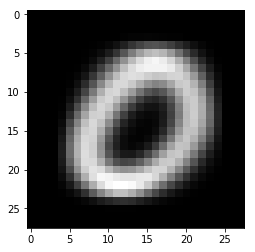

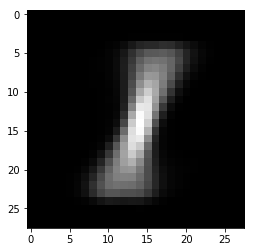

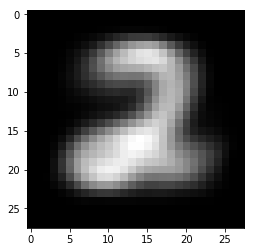

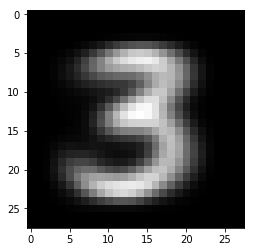

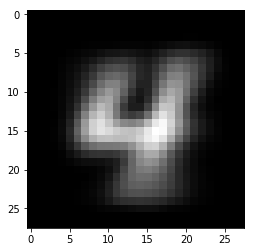

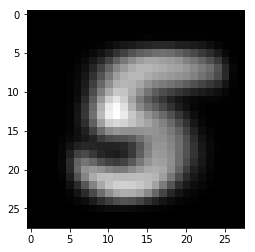

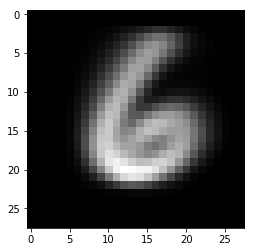

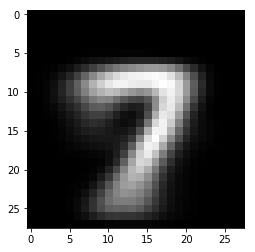

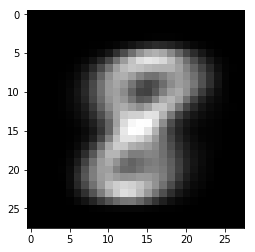

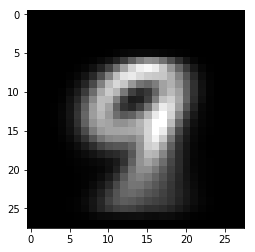

In [7]:
for mu, sigma in qda_params:
    plt.imshow(mu.reshape(28, 28), cmap='gray')
    plt.show()

You should obtain images that look like digits. If not, you've probably made a mistake. Next, we'll try to classify some of our test data and see how well our approach works.

### Part (b)
Implement the below function, that takes in the `params` you computed in the previous part, as well as a test point, and tries to determine its label. Recall that
$$
    \hat{y} = \arg\max_k \left(- \frac{1}{2}(x - \hat{\mu}_k)^T\hat{\Sigma}_k^{-1}(x - \hat{\mu}_k) - \frac{1}{2} \ln\left(|{\hat{\Sigma}_k}|\right)\right)
$$

Your covariance matrices may be singular. This will be a problem, since you need to invert them and compute the log of their determinant, both of which are undefined operations on singular matrices. There are a number of ways to get around this - here, we will simply implement a "hack", by "fuzzing" the matrix in a manner that preserves its singular values, but lifts its zero singular values up to a small nonzero value. Specifically, let $\text{fuzz}(\Sigma) = \Sigma + \varepsilon I$, where $\varepsilon$ is some small hyperparameter.

We have implemented this `fuzz` function for you with $\varepsilon = 10^{-6}$, as well as a helper function `compute_accuracy` to help you evaluate your results.

In [8]:
def compute_accuracy(predicted_labels, test_labels):
    predicted_labels = predicted_labels.reshape(-1)
    test_labels = test_labels.reshape(-1)
    n = len(predicted_labels)
    assert n == len(test_labels)   
    return np.sum(predicted_labels == test_labels) / n

eps = 1e-6

def fuzz(matrix):
    try:
        np.linalg.inv(matrix)
    except np.linalg.LinAlgError:
        return matrix + np.eye(len(matrix)) * eps
    else:
        return matrix

def classify(params, test_points):
    """
    `params` is as generated by `compute_qda_params`
    `test_points` is an array of test points, with one row for each point.
    
    You should try to vectorize as much of your solution as possible, so it does
    not take too long to run.
    """
    # reshape test_points so each test point is in a single row
    test_points = test_points.reshape(test_points.shape[0], -1)
    n, d = test_points.shape
    ### start classify ###
    densities = []
    for k, (mu, sigma) in enumerate(params):
        densities.append(
            ((test_points - mu).T * (np.linalg.inv(fuzz(sigma)) @ (test_points - mu).T)).sum(axis=0) + 
            np.linalg.slogdet(fuzz(sigma))[1]
        )
    labels = np.argmin(np.array(densities), axis=0)
    ### end classify ###
    labels = labels.reshape(-1)
    assert len(labels) == n, "{} != {}".format(len(labels), n)
    return labels

Let's see how well your classifier does on MNIST!

In [9]:
print("Train Accuracy:", compute_accuracy(classify(qda_params, training_data), training_labels))
print("Test Accuracy:", compute_accuracy(classify(qda_params, test_data), test_labels))

Train Accuracy: 0.954
Test Accuracy: 0.767


### Part (c)
Another interesting thing to plot is the train and test accuracy as a function of the number of data points. This will tell us whether we are overfitting to the training set. Fill in the code blocks to generate the plot.

Evaluating with 100 samples
Evaluating with 1100 samples
Evaluating with 2100 samples
Evaluating with 3100 samples
Evaluating with 4100 samples
Evaluating with 5100 samples
Evaluating with 6100 samples
Evaluating with 7100 samples
Evaluating with 8100 samples
Evaluating with 9100 samples


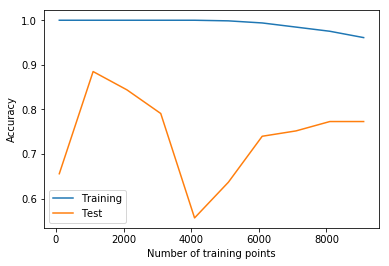

In [10]:
def accuracy_vs_n(compute_params):
    candidate_ns = range(100, 10000, 1000)
    training_accuracies = []
    test_accuracies = []
    for n in candidate_ns:
        n = int(n)
        print("Evaluating with {} samples".format(n))
        ### start compute_qda_accuracies ###
        params = compute_params(training_data[:n], training_labels[:n])
        training_accuracies.append(compute_accuracy(classify(params, training_data[:n]), training_labels[:n]))
        test_accuracies.append(compute_accuracy(classify(params, test_data), test_labels))
        ### end compute_qda_accuracies ###
    plt.plot(candidate_ns, training_accuracies, label="Training")
    plt.plot(candidate_ns, test_accuracies, label="Test")
    plt.ylabel("Accuracy")
    plt.xlabel("Number of training points")
    plt.legend()
    plt.show()
    
accuracy_vs_n(compute_qda_params)

Comment on these results. You should notice that the test accuracy fluctuates quite dramatically. One reason for this is because our estimates of the covariances for each label are very noisy, since we are only looking at one tenth of the data when calculating each covariance matrix.

### start qda-comment ###

### end qda-comment ###

### Part (d)
LDA solves this problem, by making the assumption that the covariance matrices for each class are the same $\Sigma = \Sigma_k$ for all $k$. We compute our estimate $\hat{\Sigma}$ by simply averaging the covariance matrices for each class. In principle, this estimate should be less noisy since it is constructed using much more data, so our test accuracy should not vary by as much.

Let's find out if this is the case. Implement the below function to compute the `params` to be passed into `classify` for LDA. You should reuse the `compute_qda_params` function that you previously implemented.

In [11]:
def compute_lda_params(data, labels):
    """
    Computes the mean for each class individually and the MLE covariance across all classes, 
    given labeled input data. Returns a list [(mu_0, sigma), (mu_1, sigma), ...]
    with one entry for each class
    """
    n, d = data.shape[0], data.shape[1] * data.shape[2]
    ### start lda_multi_class ###
    params = compute_qda_params(data, labels)
    sigma = np.zeros((d, d))
    for mu_k, sigma_k in params:
        sigma += sigma_k
    for i in range(10):
        params[i] = (params[i][0], sigma)
    ### end lda_multi_class ###
    assert all((sigma == params[0][1]).all() for mu, sigma in params), "Covariances are not all the same!"
    return params

We can now evaluate the LDA classifier using the `classify` function from earlier.

In [12]:
lda_params = compute_lda_params(training_data, training_labels)
print("Train Accuracy:", compute_accuracy(classify(lda_params, training_data), training_labels))
print("Test Accuracy:", compute_accuracy(classify(lda_params, test_data), test_labels))

Train Accuracy: 0.8984
Test Accuracy: 0.826


And finally, we can run the LDA classifier with a variable number of input samples:

Evaluating with 100 samples
Evaluating with 1100 samples
Evaluating with 2100 samples
Evaluating with 3100 samples
Evaluating with 4100 samples
Evaluating with 5100 samples
Evaluating with 6100 samples
Evaluating with 7100 samples
Evaluating with 8100 samples
Evaluating with 9100 samples


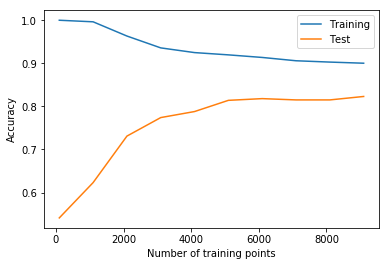

In [13]:
accuracy_vs_n(compute_lda_params)

Comment on your observations in both the LDA and QDA cases. Did you achieve the expected reduction in variation with LDA? What about in absolute terms - is it a better method than QDA? Why, or why not?

### start lda-comment ###

### end lda-comment ###

### Part (e)

One thing we can investigate further is the per-digit accuracy of our two classifiers. It is reasonable to suppose that they might be much better at classifying some digits compared to others. Run the below function to plot their per-digit training and test accuracies. It will create two plots: one with the training accuracy for each digit as a function of the number of samples, and another with the test accuracy.

This may take a while to run!

In [14]:
def digit_accuracy_vs_n(compute_params):
    candidate_ns = range(100, 10000, 1000)
    training_accuracies_by_digit = [[] for _ in range(10)]
    test_accuracies_by_digit = [[] for _ in range(10)]
    for n in candidate_ns:
        n = int(n)
        print("Evaluating with {} samples".format(n))
        params = compute_params(training_data[:n], training_labels[:n])
        predicted_training_labels = classify(params, training_data[:n])
        predicted_test_labels = classify(params, test_data)
        for k in range(10):
            training_indices_with_k = training_labels[:n] == k
            test_indices_with_k = test_labels == k
            training_accuracies_by_digit[k].append(compute_accuracy(
                predicted_training_labels[training_indices_with_k], training_labels[:n][training_indices_with_k]
            ))
            test_accuracies_by_digit[k].append(compute_accuracy(
                predicted_test_labels[test_indices_with_k], test_labels[test_indices_with_k]
            ))
    
    for k, training_accuracies in enumerate(training_accuracies_by_digit):
        plt.plot(candidate_ns, training_accuracies, label="Digit {}".format(k))
    plt.xlabel("Number of training points")
    plt.ylabel("Training accuracy")
    plt.legend()
    plt.show()

    for k, test_accuracies in enumerate(test_accuracies_by_digit):
        plt.plot(candidate_ns, test_accuracies, label="Digit {}".format(k))
    plt.xlabel("Number of training points")
    plt.ylabel("Test accuracy")
    plt.legend()
    plt.show()

Evaluating with 100 samples
Evaluating with 1100 samples
Evaluating with 2100 samples
Evaluating with 3100 samples
Evaluating with 4100 samples
Evaluating with 5100 samples
Evaluating with 6100 samples
Evaluating with 7100 samples
Evaluating with 8100 samples
Evaluating with 9100 samples


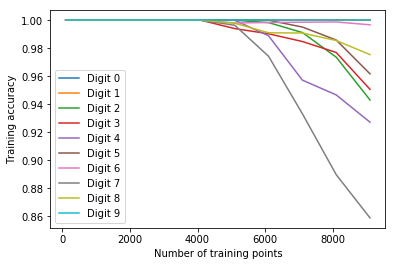

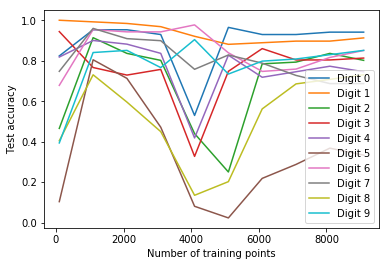

In [15]:
# For QDA
digit_accuracy_vs_n(compute_qda_params)

Evaluating with 100 samples
Evaluating with 1100 samples
Evaluating with 2100 samples
Evaluating with 3100 samples
Evaluating with 4100 samples
Evaluating with 5100 samples
Evaluating with 6100 samples
Evaluating with 7100 samples
Evaluating with 8100 samples
Evaluating with 9100 samples


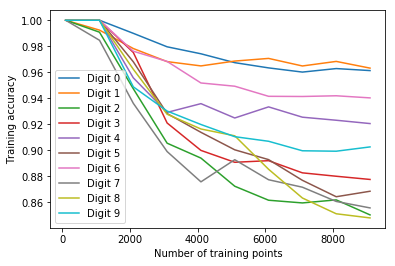

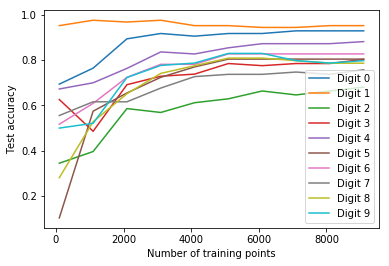

In [16]:
# For LDA
digit_accuracy_vs_n(compute_lda_params)

Comment on your results. Which digits were easy to classify? Which were harder? Why might this be the case? Did it differ between LDA and QDA?

### start digit-comment ###

### end digit-comment ###

### Part (f)

Finally, we will return to our discussion of singular covariance matrices. Recall that the `fuzz` function perturbed our covariance matrix to lift the zero eigenvalues up to some small `eps`, a hyperparameter that we arbitrarily set to $10^{-6}$. Now, you should experiment with different choices for `eps`, to attempt to choose the optimal hyperparameter. 

For simplicity, we will only consider tuning `eps` to optimize the performance of LDA, since the accuracy of QDA with this few data points is too noisy to obtain reliable results.

Implement the `tune_eps` and `compute_validation_score` functions. Consider what would be an appropriate range of hyperparameters, as well as how the test values will be spaced over that interval.

In [17]:
def tune_eps(validation_score):
    """
    validation_score() is a zero-argument function that returns
    the validation accuracy of some model. `eps` is passed into it
    by modifying it as a global variable.
    
    You should try at least 10 different values of `eps`.
    """
    global eps
    
    best_eps = None
    best_validation = 0
    
    ### start tune_eps ###
    for eps in np.logspace(-8, 2, 15):
        curr_validation = validation_score()
        if curr_validation > best_validation:
            best_validation = curr_validation
            best_eps = eps
        print("eps = {} gives validation accuracy = {}".format(eps, curr_validation))
    ### end tune_eps ###
    
    eps = best_eps
    return best_eps

def compute_validation_score(compute_params):
    def validation_score():
        # update these lines
        hyper_tuning_training_data = ...
        hyper_tuning_training_labels = ...
        hyper_tuning_validation_data = ...
        hyper_tuning_validation_labels = ...

        ### start split_validation ###
        hyper_tuning_training_data = training_data[:8000]
        hyper_tuning_training_labels = training_labels[:8000]
        hyper_tuning_validation_data = training_data[8000:]
        hyper_tuning_validation_labels = training_labels[8000:]
        ### end split_validation ###

        return compute_accuracy(classify(
            compute_params(hyper_tuning_training_data, hyper_tuning_training_labels),
            hyper_tuning_validation_data,
        ), hyper_tuning_validation_labels)

    return validation_score

In [19]:
print("Best epsilon for LDA:", tune_eps(compute_validation_score(compute_lda_params)))

eps = 1e-08 gives validation accuracy = 0.8495
eps = 5.1794746792312124e-08 gives validation accuracy = 0.85


KeyboardInterrupt: 

In [ ]:
print("Best epsilon for QDA:", tune_eps(compute_validation_score(compute_qda_params)))

Did your hyperparameter tuning work? Why or why not? Comment on your observations.

### start eps-comment ###

### end eps-comment ###